<a href="https://colab.research.google.com/github/tlysenko/CreditScoring/blob/master/Credit_Scoring_EDA_and_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plan
*   **Data Preparation**
  *   Importing libraries
  *   Importing data and renaming the columns
  *   Discovering missing values
    *   Imputing missing values
*   **EDA**
  *   Target variable
    *   Dealing with unbalanced dataset
  *   DebtRate variable
  *   RevUnsec variable
  *   Age variable
*   **Feature Engineering**
  * Evaluating features impact on Target variable
* **Conclusion**



# Data Preparation

### Importing libraries

In [0]:
import pandas as pd

from sklearn.preprocessing import Imputer

import matplotlib.pyplot as plt
import seaborn as sns


#### Importing data and renaming the columns

In [0]:
def get_data(file):
  df = pd.read_csv(file, sep=';',na_values=' ')

  def rename_cols(df):

      df = df.rename(columns = {'SeriousDlqin2yrs': 'Target',
                                          'age': 'Age',
                                          'RevolvingUtilizationOfUnsecuredLines' : 'RevUnsec',
                                          'NumberOfOpenCreditLinesAndLoans' : 'NumLoans',
                                          'NumberOfTimes90DaysLate' : '90-Late',
                                          'NumberOfTime3059DaysPastDueNotWorse': '30-59-Late',
                                          'NumberOfTime6089DaysPastDueNotWorse': '60-89-Late' ,
                                          'NumberRealEstateLoansOrLines': 'R_EstateLoans',
                                          'NumberOfDependents': 'Dependts'
                                          })
      return df

  df = rename_cols(df)
  return df

In [0]:
df_train=get_data("scoring_train_data.csv")
df_test=get_data("scoring_test_data.csv")

In [0]:
df_train.shape, df_test.shape

((104681, 12), (45319, 11))

In [0]:
df_train.head()

,Target,RevUnsec,Age,30-59-Late,DebtRatio,MonthlyIncome,NumLoans,90-Late,R_EstateLoans,60-89-Late,Dependts,Ident
0,1,0.766127,45,2,0.802982,9120.0,13,0,4,0,2.0,90.0
1,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,116.0
2,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,153.0
3,0,0.305682,57,0,4981.000000,NaN,8,0,3,0,0.0,432.0
4,0,0.116951,29,0,46.000000,NaN,2,0,0,0,NaN,818.0


In [0]:
df_train.nunique()

Target                2
RevUnsec          86055
Age                  59
30-59-Late            5
DebtRatio         79459
MonthlyIncome     11091
NumLoans             23
90-Late               4
R_EstateLoans         5
60-89-Late            3
Dependts              5
Ident            104681
dtype: int64

The following varibles need to be Dummy encoded:

*   30-59-Late
*   90-Late
*   60-89-Late
*   Dependts




### Discovering missing values

In [0]:
df_train.isna().sum()

Target               0
RevUnsec             0
Age                  0
30-59-Late           0
DebtRatio            0
MonthlyIncome    20691
NumLoans             0
90-Late              0
R_EstateLoans        0
60-89-Late           0
Dependts          2744
Ident                0
dtype: int64

**The approach for handling missing values need to be defined. We can either Impute them or delete. For the purpose of this EDA we will impute missing values.**

###### Imputing missing values

In [0]:
imputer = Imputer(missing_values = 'NaN', strategy = 'median',axis=0)
imputer.fit(df_train['MonthlyIncome'].values.reshape(-1,1))
df_train['MonthlyIncome'] = imputer.transform(df_train['MonthlyIncome'].values.reshape(-1,1))

imputer.fit(df_train['Dependts'].values.reshape(-1,1))
df_train['Dependts'] = imputer.transform(df_train['Dependts'].values.reshape(-1,1))

## Target variable

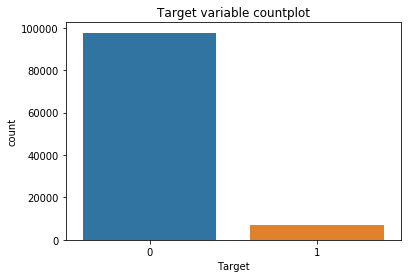

In [0]:
plt.title('Target variable countplot')
sns.countplot(df_train['Target']);

In [0]:
print("Target class '1' represents only {:.3}% from the total Target variable distribution. This means we're dealing with the unbalanced dataset. ".format(df_train[df_train['Target']==1]['Target'].count() / df_train['Target'].count()*100))

Target class '1' represents only 6.68% from the total Target variable distribution. This means we're dealing with the unbalanced dataset. 


### Dealing with unbalanced dataset

*  Using *stratify=y* parameter at *train_test_split*
*  Using StratifiedKfold for cross validation
*  Using ROC_AUC metric for scoring
*  Making sure confusion matrix is resonable 
*  Using penalized regression
*  Use undersampling and oversampling


## DebtRate variable

### Train data distrbution

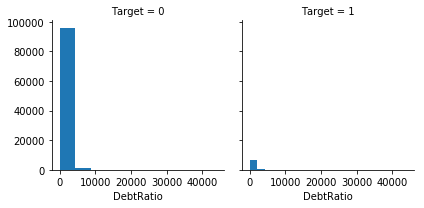

In [0]:
g = sns.FacetGrid(df_train, col="Target",margin_titles=True)
g.map(plt.hist, 'DebtRatio');

In [0]:
print('{:.3}% of the target variable class are in the greater than 1 area'.format(df_train[(df_train['Target']==1) & (df_train['DebtRatio'] > 1)]['Ident'].count() \
                                                                               / df_train[df_train['Target']==1]['Ident'].count()*100))

22.8% of the target variable class are in the greater then 1 area


### Test data DebtRatio distribution

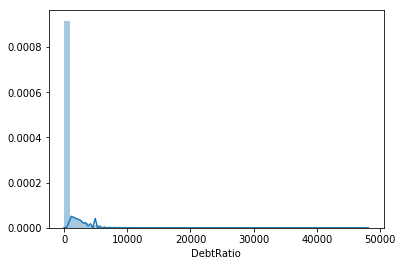

In [0]:
sns.distplot(df_test['DebtRatio']);

**22.8% of greater than one values means person's monhtly loan payment is equal to the monthly income which seems unresonable. At the same time there is a low correlation of these values with the Target variable.** 

## RevUnsec variable


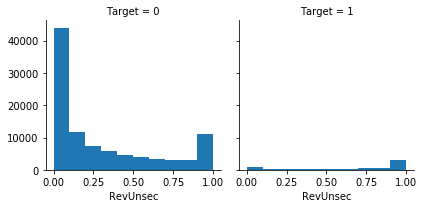

In [0]:
g = sns.FacetGrid(df_train, col="Target",margin_titles=True)
g.map(plt.hist, 'RevUnsec');

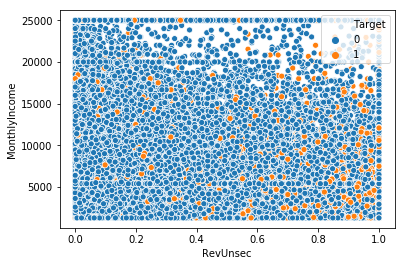

In [0]:
sns.scatterplot(data=df_train, x='RevUnsec', y='MonthlyIncome', hue='Target');

### Test data RevUnsec distribution 

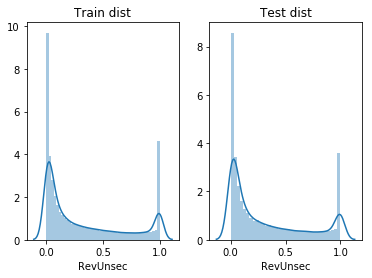

In [0]:
plt.subplot(1,2,1)
plt.title('Train dist');
sns.distplot(df_train['RevUnsec']);
plt.subplot(1,2,2)
plt.title('Test dist')
sns.distplot(df_test['RevUnsec']);


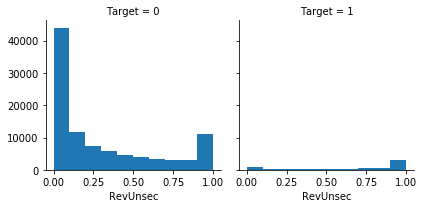

In [0]:
g = sns.FacetGrid(df_train, col="Target",margin_titles=True)
g.map(plt.hist, 'RevUnsec');

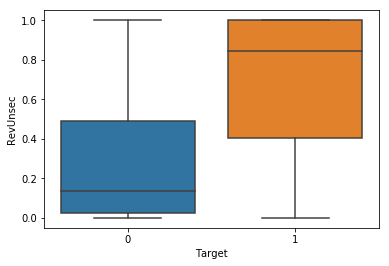

In [0]:
sns.boxplot(data = df_train, x ='Target',y='RevUnsec');

**There is a visible correlation between RevUnsec and target variables**

## Age variable

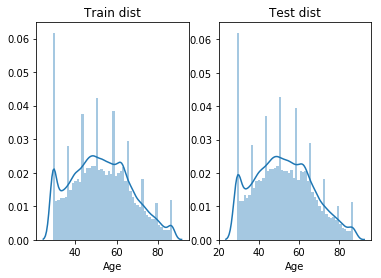

In [0]:
plt.subplot(1,2,1)
plt.title('Train dist');
sns.distplot(df_train['Age']);
plt.subplot(1,2,2)
plt.title('Test dist')
sns.distplot(df_test['Age']);


In [0]:
print('Minimal age in train_df {}, minimal age in test_df {}.'.format(min(df_train['Age']) , min(df_test['Age'])))

Minimal age in train_df 29, minimal age in test_df 29.


In [0]:
print('Maximum age in train_df {}, maximum age in test_df {}.'.format(max(df_train['Age']) , max(df_test['Age'])))

Maximum age in train_df 87, maximum age in test_df 87.


**Age distribution is fairly valid, doesn't seem to contain outliers and is similar in train_df and test_df.**

## 30-59-Late, 60-89-Late, 90-Late variables

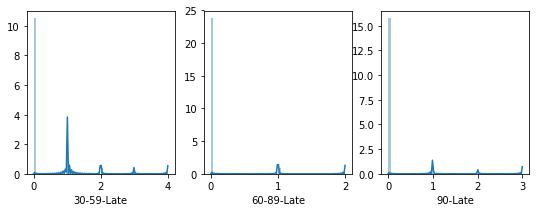

In [0]:
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
sns.distplot(df_train['30-59-Late'])
plt.subplot(1,3,2)
sns.distplot(df_train['60-89-Late'])
plt.subplot(1,3,3)
sns.distplot(df_train['90-Late']);

**The most people are missing only one payment in 30 days and than they pick up on the schedule.**

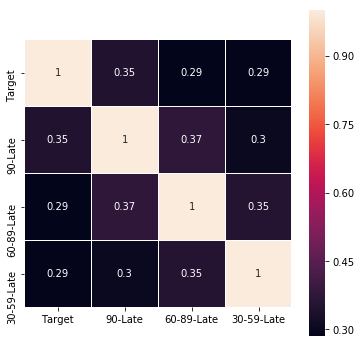

In [0]:
plt.figure(figsize=(6,6))
sns.heatmap(df_train[['Target','90-Late','60-89-Late','30-59-Late']].corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

**All three variables contribute to the target variable and at the same time are correleted with each other.**





# Feature Engineering

### Feature: Has a dependent

In [0]:
df_train['HasDependent'] = [int(x>0) for x in df_train['Dependts']]

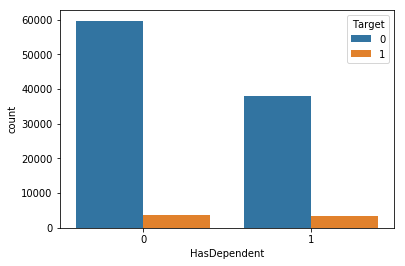

In [0]:
sns.countplot(data=df_train,x=df_train['HasDependent'],hue='Target');

### Feature: Retired

In [0]:
df_train['Retired'] = [ int(x>66) for x in df_train['Age'] ]

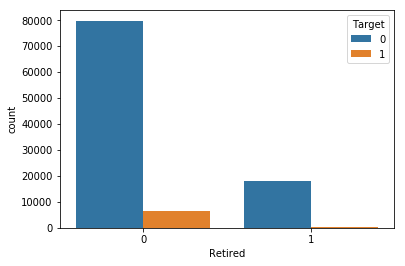

In [0]:
sns.countplot(data=df_train,x=df_train['Retired'],hue='Target');

### Feature: RevUnsecIncome

In [0]:
df_train['RevUnsecIncome'] = [Inc*Rev for Rev, Inc in zip(df_train['RevUnsec'],df_train['MonthlyIncome'])]

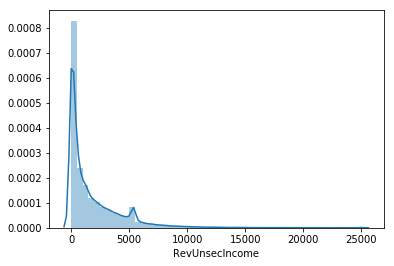

In [0]:
sns.distplot(df_train['RevUnsecIncome']);

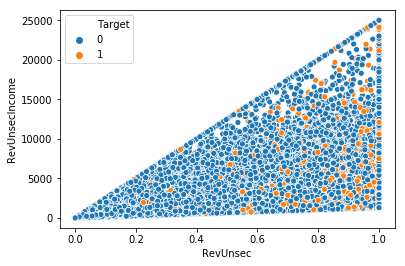

In [0]:
sns.scatterplot(data=df_train, x='RevUnsec', y='RevUnsecIncome', hue='Target');

### Feature: Unhealthy RevUnsec and Income

In [0]:
df_train['UnhealthyRevUnsecIncome'] = [int(Inc*Rev < 500) for Rev, Inc in zip(df_train['RevUnsec'],df_train['MonthlyIncome'])]
df_train['UnhealthyRevUnsecRatio'] = [int(x<0.75) for x in df_train['RevUnsec']]

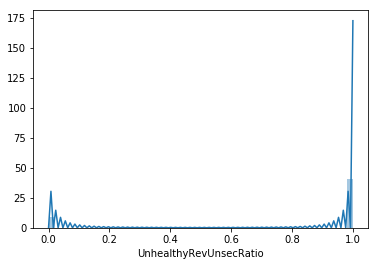

In [0]:
sns.distplot(df_train['UnhealthyRevUnsecRatio']);

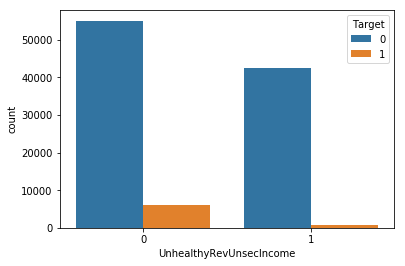

In [0]:
sns.countplot(data=df_train,x=df_train['UnhealthyRevUnsecIncome'],hue='Target');

### Feature: IncomeLeft

In [0]:
df_train['IncomeLeft'] = [Inc*Deb for Deb, Inc in zip(df_train['DebtRatio'],df_train['MonthlyIncome'])]

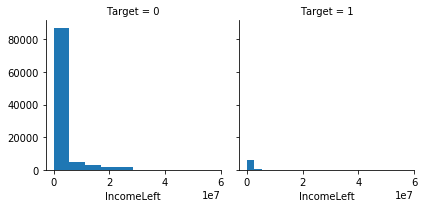

In [0]:
g = sns.FacetGrid(df_train, col="Target",margin_titles=True)
g.map(plt.hist, 'IncomeLeft');

### Feature: IncomeLeftTresshold

In [0]:
df_train['IncomeLeftTresshold'] = [int(Inc*Rev < 2000) for Rev, Inc in zip(df_train['DebtRatio'],df_train['MonthlyIncome'])]

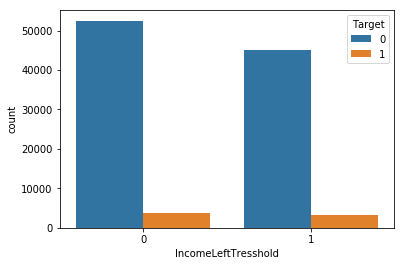

In [0]:
sns.countplot(data=df_train,x=df_train['IncomeLeftTresshold'],hue='Target');

### Feature: UnhealthyDebt

In [0]:
df_train['UnhealthyDebt'] = [int(x<0.75) for x in df_train['DebtRatio']]

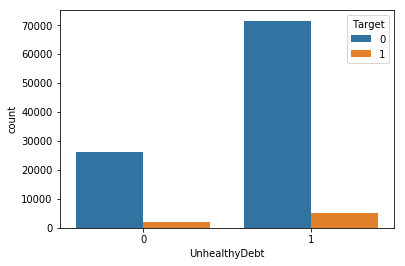

In [0]:
sns.countplot(data=df_train,x=df_train['UnhealthyDebt'],hue='Target');

## Evaluating features impact on Target variable

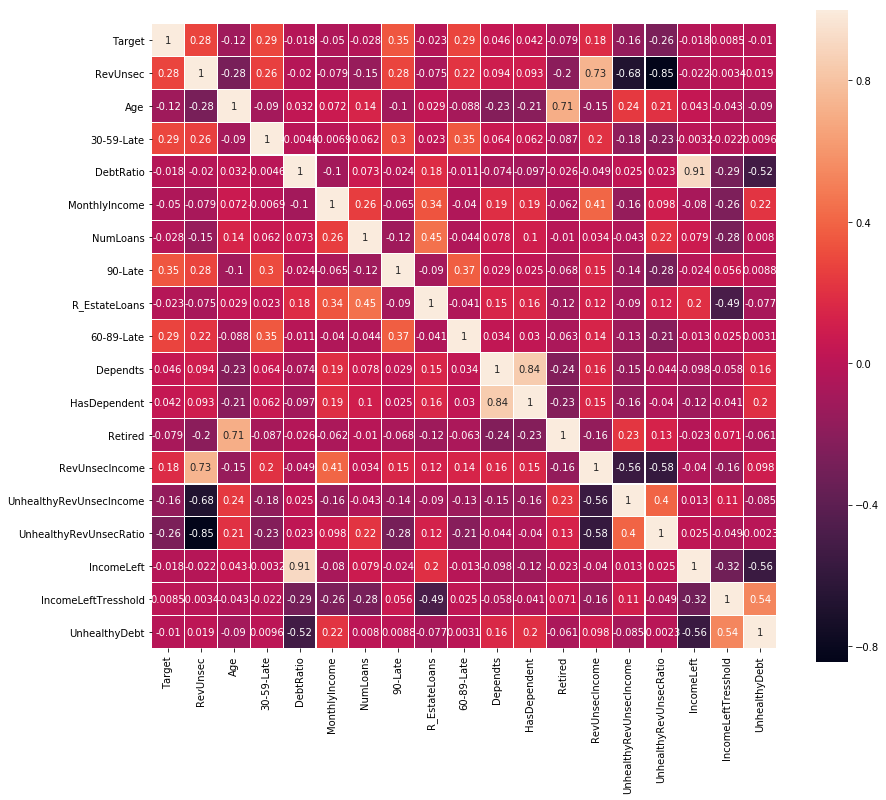

In [0]:
#Building heatmap
plt.figure(figsize=(14,12))
sns.heatmap(df_train.drop('Ident',axis=1).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

In [0]:
df_test.columns

Index(['RevUnsec', 'Age', '30-59-Late', 'DebtRatio', 'MonthlyIncome',
       'NumLoans', '90-Late', 'R_EstateLoans', '60-89-Late', 'Dependts',
       'Ident'],
      dtype='object')

# Conclusion

For the purpose of this EDA NAs has been Imputed but the alternative approach of removing is investigated at the later stage. 

All of the newly added features (Retired, InhealthyRevUnsecIncome, InhealthyRevUnsecRatio, IncomeLeft, IncomeLeftTresshold, InhealthyDebt) do not contribute to the target variable for more than the features they've been based upon so no of them will be added to the train dataset.


